# Using Deep Learning to Detect Atelectasis In X-Rays


## Pre-Processing Data
The NIH dataset had over 100,000 chest x-rays images available. Due to GPU constraints, we decided to narrow our analysis down to 10,000 images, and focus on the detection of Atelectasis. We also added an additional column HasDisease to the csv that indicated if Atelectasis had been detected or not. 

In [14]:
import numpy as np
import pandas as pd
import scipy.misc
import os
import random
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from matplotlib import pyplot
from scipy.misc import toimage
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from PIL import Image

CSV = 'Data_Final_proj.csv'

data = pd.read_csv(CSV)
image_index = list(data['Image Index'])
has_disease = list(data['HasDisease'])

def load_data(directory, index, labels):
    filenames = [os.path.join(directory, i) for i in index]
    label = [1. if d == 'TRUE' else 0. for d in labels]     
    return np.array(filenames), np.array(label)

split_index = int(.8 * len(image_index))
train_x, train_y = load_data('image_list/', image_index[:split_index], has_disease[:split_index])
test_x, test_y = load_data('image_list/', image_index[split_index:], has_disease[split_index:])


In [31]:
data.head()

,Image Index,Labels,Follow Up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,HasDisease
0,00000637_000.png,No Finding,0,637,55,F,PA,2522,2991,0.143,0.143,FALSE
1,00005742_004.png,Atelectasis,4,5742,60,M,AP,2500,2048,0.171,0.171,TRUE
2,00000613_001.png,No Finding,1,613,61,M,PA,2992,2991,0.143,0.143,FALSE
3,00011973_001.png,Atelectasis,1,11973,65,M,AP,3056,2544,0.139,0.139,TRUE
4,00009640_001.png,Atelectasis,1,9640,25,F,AP,2500,2048,0.168,0.168,TRUE


In [15]:
def load_image(path, size=224):
    img = Image.open(path.strip())
    img = img.convert("RGB")
    img = np.array(img, np.float32)
    img = scipy.misc.imresize(img, (size, size))
    return img

X_train = [load_image(i) for i in train_x]
X_test = [load_image(i) for i in test_x]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [16]:
trainx = np.array(X_train)
testx = np.array(X_test)

In [17]:
# Normalize Data
trainx = trainx.astype('float32')
testx = testx.astype('float32')
trainx /= 255
testx /= 255

# Data Augmentations
Our data augmentations were flipping to the left, down, and 90 degree rotation. We decided not to perform any drastic augmentations since X-rays are typically examined in their correct orientation. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


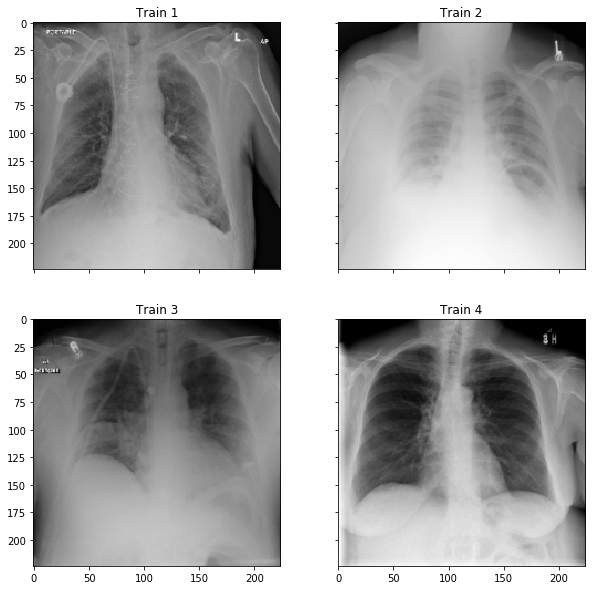

In [18]:
h1 = load_image(train_x[3])
h2 = load_image(train_x[4])
h3 = load_image(train_x[5])
h4 = load_image(train_x[6])
    
f, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0, 0].imshow(h1)
axarr[0, 0].set_title('Train 1')
axarr[0, 1].imshow(h2)
axarr[0, 1].set_title('Train 2')
axarr[1, 0].imshow(h3)
axarr[1, 0].set_title('Train 3')
axarr[1, 1].imshow(h4)
axarr[1, 1].set_title('Train 4')

for ax in axarr.flat:
    ax.label_outer()

In [19]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

In [20]:
def augmentation_1(img):
    
    augmented_img = np.flipud(img)

    
    return augmented_img

In [21]:
def augmentation_2(img):
    
    augmented_img = np.rot90(img)
    
    return augmented_img

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


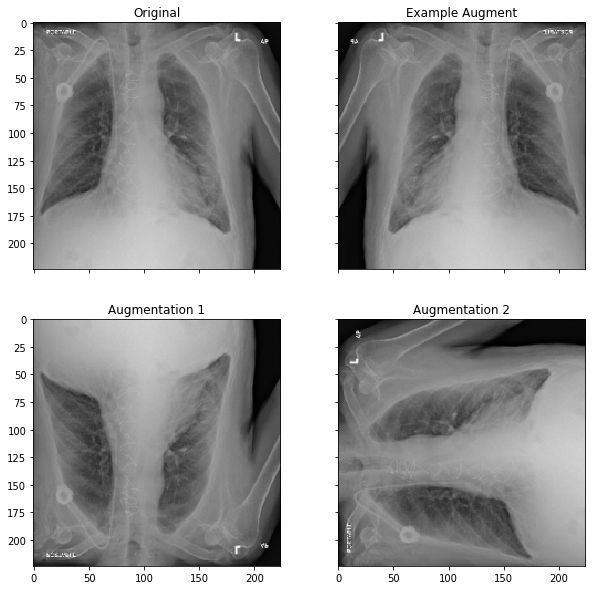

In [22]:
sample_img = load_image(train_x[3])
f, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()


Below we add the original x-rays, to the augmented x-rays. 

In [23]:
def augment_data(data=trainx, labels=train_y, probability=0.33):
    X_augment = []
    y_augment = []
    for (img, label) in zip(data, labels):
        random_number = random.random()
        if (random_number > 2*probability):
            img_augment = example_augment(img)
        elif (random_number > probability and random_number <= 2 * probability):
            img_augment = augmentation_1(img)
        else:
            img_augment = augmentation_2(img)
        X_augment.append(img_augment)
        y_augment.append(label)

    X_augment = np.concatenate((data, X_augment), axis=0)
    y_augment = np.concatenate((labels, y_augment), axis=0)
    return X_augment, y_augment

# Model Architecture
An architecture very similar to VGG-16 was used with two sets of two convolution layers, and a max pooling layer, and three sets of three convolution layers, and a max pooling layer. 

In [24]:
from keras.layers import MaxPool2D
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
__________

In [25]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [26]:
X_train, y_train = augment_data(data=trainx, labels=train_y, probability=0.33)

X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
testx = testx.reshape(testx.shape[0], 224, 224, 3)

In [27]:
history = model.fit(X_train, y_train, batch_size = 16, epochs=3, verbose=1, validation_split=0.2)

Train on 12800 samples, validate on 3200 samples
Epoch 1/3
12800/12800 [==============================] - 503s 39ms/step - loss: 0.6960 - acc: 0.4983 - val_loss: 0.6931 - val_acc: 0.5003
Epoch 2/3
12800/12800 [==============================] - 495s 39ms/step - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 3/3
12800/12800 [==============================] - 495s 39ms/step - loss: 0.6932 - acc: 0.4907 - val_loss: 0.6931 - val_acc: 0.4997


In [30]:
import json
# Save the weights for grading.
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)